# Image Captioning Neural Model (SC4001)

In [1]:
!pip install pillow opencv-python pydot


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!brew install graphviz

'brew' is not recognized as an internal or external command,
operable program or batch file.


In [440]:
import os
from PIL import Image
import cv2
import random
from textwrap import wrap

import math
import pickle

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydot

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, Add, Concatenate, Reshape, concatenate, Bidirectional, RepeatVector
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [225]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### 1.1 Retrieving the datasets

In [227]:
captions = pd.read_csv('./flickr8k_images/captions.txt', delimiter=',')
image_path = './flickr8k_images/Images'
images = os.listdir(image_path)

valid_imgExt = [".jpg", ".jpeg", ".png"]

image_size = [(64, 64), (128, 128), (224, 224), (256, 256)]

# We will first use (224, 244) image size

def show_images(num, images):
    plt.figure(figsize=(25, 25))

    # Randomly select images
    r = random.randint(0, len(images)-num-1)

    for i, filename in enumerate(images[r:r+num]):
        if os.path.splitext(filename)[1].lower() not in valid_imgExt:
            continue
        with open(os.path.join(image_path, filename), 'rb') as img:
            img = Image.open(img).resize(image_size[2])
            plt.subplot(5, 5, i+1)
            plt.imshow(img)
            plt.title("\n".join(wrap(get_caption(filename, captions), 20)))
            plt.subplots_adjust(hspace=0.8)
            img.close()

    plt.show()

def get_caption(filename, captions):
    cap = captions[captions['image'] == filename]['caption'].values
    return cap[random.randint(0, len(cap)-1)]

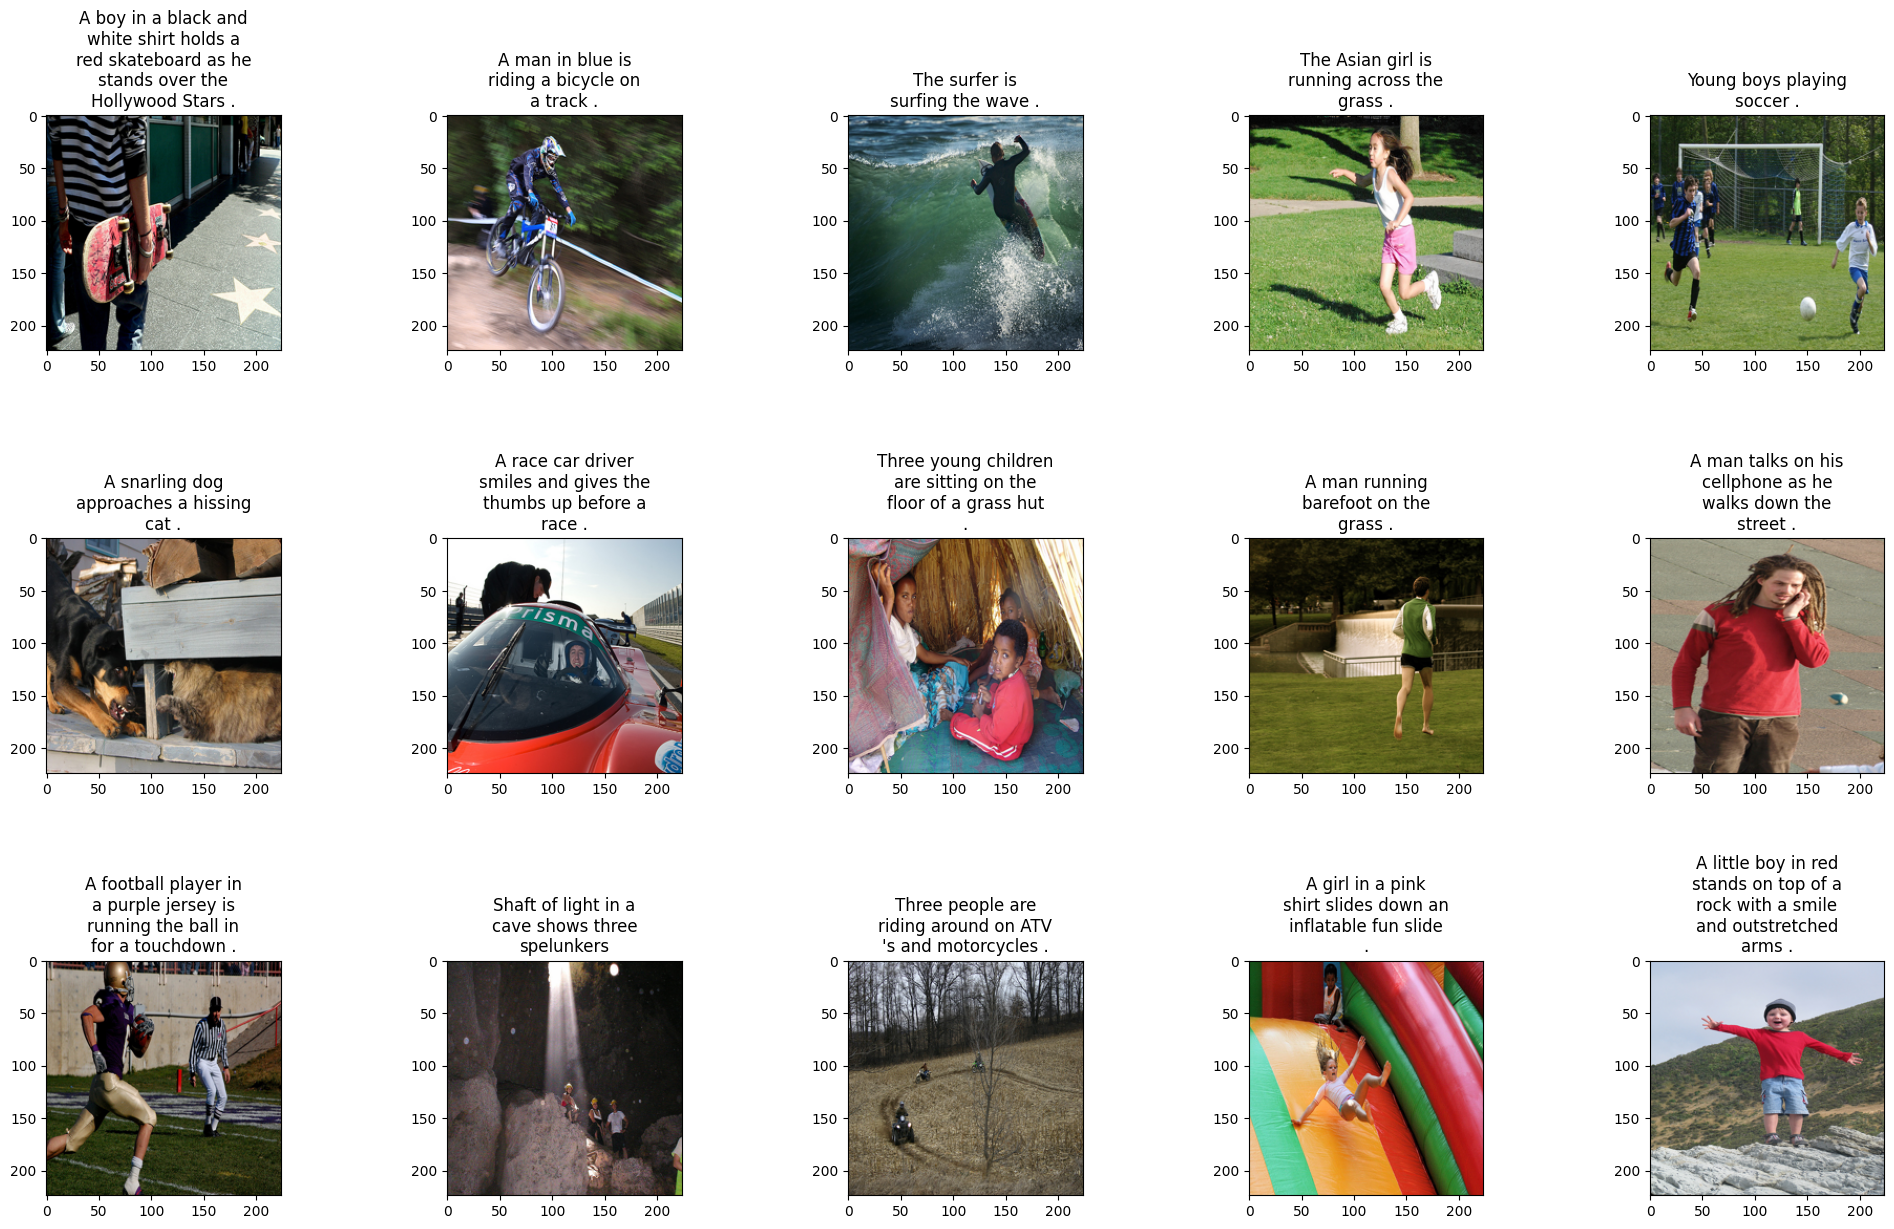

In [228]:
show_images(15, images)

### 1.2 Analysing datasets
- Images
- Captions

In [229]:
# images dataset
total_width = total_height = 0

for filename in images:
    try:
        if os.path.splitext(filename)[1].lower() not in valid_imgExt:
            continue
        with open(os.path.join(image_path, filename), 'rb') as file:
            img = Image.open(file)
            width, height = img.size

            total_width += width
            total_height += height
            img.close()
    except Exception as e:
        print(f"Skipping {filename} due to error: {e}")

average_width = total_width / len(images)
average_height = total_height / len(images)

print(f"Average Width: {average_width:.4f}")
print(f"Average Height: {average_height:.4f}")

Average Width: 457.8722
Average Height: 397.2519


In [230]:
# captions dataset
display(captions.head(10))
print("We observe that there are multiple captions for each image.")

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

We observe that there are multiple captions for each image.


### 2.1 Clean captions dataset

- Convert all char to lowercase
- Remove unncecessary white spaces
- Only allow valid char in the English language
- Remove special char eg. '&', '*', '(', ')', etc

In [234]:
def text_preprocessing(df):
    df['caption'] = df['caption'].str.lower()
    df['caption'] = df['caption'].str.replace("[^A-Za-z]", " ", regex=True)
    df['caption'] = df['caption'].str.replace("\s+", " ", regex=True)
    df['caption'] = df['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    df['caption'] = "Sseq " + df['caption'] + " Eseq"
    return df

captions_clean = captions.copy()
captions_clean = text_preprocessing(captions_clean)
captions_list = captions_clean['caption'].tolist()
captions_list[:10]

['Sseq child in pink dress is climbing up set of stairs in an entry way Eseq',
 'Sseq girl going into wooden building Eseq',
 'Sseq little girl climbing into wooden playhouse Eseq',
 'Sseq little girl climbing the stairs to her playhouse Eseq',
 'Sseq little girl in pink dress going into wooden cabin Eseq',
 'Sseq black dog and spotted dog are fighting Eseq',
 'Sseq black dog and tri colored dog playing with each other on the road Eseq',
 'Sseq black dog and white dog with brown spots are staring at each other in the street Eseq',
 'Sseq two dogs of different breeds looking at each other on the road Eseq',
 'Sseq two dogs on pavement moving toward each other Eseq']

In [252]:
# Creating a descriptions{} to group captions with their respective filename
descriptions = {}

for index, row in captions_clean.iterrows():
    image_name = row['image']
    comment = row['caption']
    
    # If image_name is not in the dictionary, create a new entry
    if image_name not in descriptions:
        descriptions[image_name] = [comment]
    else:
        # If image_name is already in the dictionary, append the comment to the existing list
        descriptions[image_name].append(comment)

list(descriptions.items())[:2]

[('1000268201_693b08cb0e.jpg',
  ['Sseq child in pink dress is climbing up set of stairs in an entry way Eseq',
   'Sseq girl going into wooden building Eseq',
   'Sseq little girl climbing into wooden playhouse Eseq',
   'Sseq little girl climbing the stairs to her playhouse Eseq',
   'Sseq little girl in pink dress going into wooden cabin Eseq']),
 ('1001773457_577c3a7d70.jpg',
  ['Sseq black dog and spotted dog are fighting Eseq',
   'Sseq black dog and tri colored dog playing with each other on the road Eseq',
   'Sseq black dog and white dog with brown spots are staring at each other in the street Eseq',
   'Sseq two dogs of different breeds looking at each other on the road Eseq',
   'Sseq two dogs on pavement moving toward each other Eseq'])]

### 2.2 Tokenise captions dataset

In [403]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_list)
vocab_size = len(tokenizer.word_index) + 1
max_length = 0
for captions in captions_clean['caption']:
    if len(captions.split()) > max_length:
        max_length = len(captions.split())
print(f"max_length of sequence: {max_length}")

images = captions_clean['image'].unique().tolist()

# Randomize the order of the images
random.seed(8)
random.shuffle(images)

# 75% training, 15% validation, 10% test
split_train = 0.75
split_val = 0.15
split_test = 0.10

split_index = round(split_train * len(images))
train_images = images[:split_index]
valtest_images = images[split_index:]

# Calculate the split indices
val_index = round(2/3 * len(valtest_images))
val_images = valtest_images[:val_index]
test_images = valtest_images[val_index:]
test = captions_clean[captions_clean['image'].isin(test_images)]
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions_list[1]])[0]

max_length of sequence: 35


[1, 18, 313, 63, 194, 116, 2]

### 2.3 Data Generator

In [367]:
def data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size, shuffle=True):
    while True:  # Loop forever so the generator never terminates
        keys = list(descriptions.keys())
        if shuffle:
            np.random.shuffle(keys)
        
        # Loop over the image identifiers in the descriptions
        for i in range(0, len(keys), batch_size):
            batch_keys = keys[i:i+batch_size]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, vocab_size, descriptions, features, batch_keys)
            yield [[np.array(inp_image), np.array(inp_seq)], np.array(op_word)]

def create_sequences(tokenizer, max_length, vocab_size, descriptions, features, batch_keys):
    x_1, x_2, y = [], [], []
    # Loop over each image identifier in the batch
    for key in batch_keys:
        # Retrieve the photo feature
        feature = features[key][0]
        # Get all descriptions for the image
        desc_list = descriptions[key]
        for desc in desc_list:
            # Encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # Split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # Split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # Pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # Encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # Store
                x_1.append(feature)
                x_2.append(in_seq)
                y.append(out_seq)
    return x_1, x_2, y

### 3.1 Define pretrained CNN models for image feature extraction

In [248]:
model1, model2, model3, model4 = VGG16(), DenseNet201(), InceptionV3(), ResNet50()

### 3.1.1 Feature extraction

In [249]:
features1 = features2 = features3 = features4 = {}

feature_ex1 = Model(inputs=model1.input, outputs=model1.layers[-2].output)
feature_ex2 = Model(inputs=model2.input, outputs=model2.layers[-2].output)
feature_ex3 = Model(inputs=model3.input, outputs=model3.layers[-2].output)
feature_ex4 = Model(inputs=model4.input, outputs=model4.layers[-2].output)

def feature_extraction(feature_ex, images, features):
    for filename in tqdm(images):
        try:
            if os.path.splitext(filename)[1].lower() not in valid_imgExt:
                continue
            with open(os.path.join(image_path, filename), 'rb') as img:
                img = Image.open(img).resize(image_size[2])
                img = img_to_array(img)
                # Normalise image pixel values [0,255] -> [0,1]
                img = img/255
                img = np.expand_dims(img, axis=0)
                feature = feature_ex(img)
                features[filename] = feature
        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

In [251]:
# model1 VGG16

# NOTE: Uncomment the following when running feature extraction again
# feature_extraction(feature_ex1, images, features1)
# with open('./fe_dict_save/features1_8k.pkl', 'wb') as file:
#     pickle.dump(features1, file)

# NOTE: Retrieves the features extracted from images
with open('./fe_dict_save/features1_8k.pkl', 'rb') as file:
    features1 = pickle.load(file)

100%|██████████| 8091/8091 [25:02<00:00,  5.38it/s] 


In [15]:
# model2 DenseNet201

# NOTE: Uncomment the following when running feature extraction again
# feature_extraction(feature_ex2, images, features2)
# with open('./fe_dict_save/features2.pkl', 'wb') as file:
#    pickle.dump(features2, file)

# NOTE: Retrieves the features extracted from images
# with open('./fe_dict_save/features2.pkl', 'rb') as file:
#     features2 = pickle.load(file)

In [16]:
# model3 InceptionV3

# NOTE: Uncomment the following when running feature extraction again
# feature_extraction(feature_ex3, images, features3)
# with open('./fe_dict_save/features3.pkl', 'wb') as file:
#     pickle.dump(features3, file)

# NOTE: Retrieves the features extracted from images
# with open('./fe_dict_save/features3.pkl', 'rb') as file:
#     features3 = pickle.load(file)
# # input 0 of layer 'model_2' is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(1, 224, 22

In [17]:
# model4 ResNet50

# NOTE: Uncomment the following when running feature extraction again
#feature_extraction(feature_ex4, images, features1)
#with open('./fe_dict_save/features4.pkl', 'wb') as file:
#    pickle.dump(features4, file)

# NOTE: Retrieves the features extracted from images
# with open('./fe_dict_save/features4.pkl', 'rb') as file:
#     features4 = pickle.load(file)

### 3.2 Define the network (CNN + LSTM)
Default CNN: VGG16

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_76 (InputLayer)       [(None, 35)]                 0         []                            
                                                                                                  
 input_75 (InputLayer)       [(None, 4096)]               0         []                            
                                                                                                  
 embedding_31 (Embedding)    (None, 35, 256)              2157312   ['input_76[0][0]']            
                                                                                                  
 dropout_22 (Dropout)        (None, 4096)                 0         ['input_75[0][0]']            
                                                                                           

Python(10446) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(10447) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


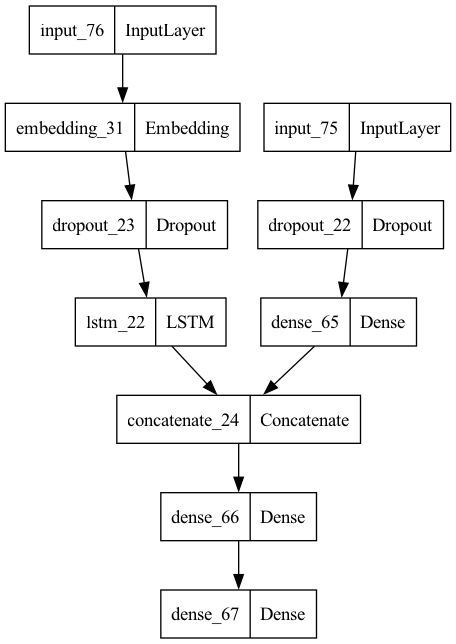

In [260]:
input1 = Input(shape=(4096,))
input2 = Input(shape=(max_length,))

img_features_1 = Dropout(0.4)(input1)
img_features_2 = Dense(256, activation='relu')(img_features_1)

sentence_features_1 = Embedding(vocab_size, 256, mask_zero=False)(input2)
sentence_features_2 = Dropout(0.4)(sentence_features_1)
sentence_features_3 = LSTM(256)(sentence_features_2)

merged = concatenate([img_features_2, sentence_features_3], axis=1)
decoder = Dense(256, activation = 'relu')(merged)
output = Dense(vocab_size, activation='softmax')(decoder)

model = Model(inputs=[input1, input2], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()
plot_model(model)

In [442]:
# Split the descriptions into training and validation sets
train_descriptions = {k: v for k, v in descriptions.items() if k in train_images}
val_descriptions = {k: v for k, v in descriptions.items() if k in val_images}

batch_size = 64
num_epochs = 50

train_generator1 = data_generator(train_descriptions, features1, tokenizer, max_length, vocab_size, batch_size)
val_generator1 = data_generator(val_descriptions, features1, tokenizer, max_length, vocab_size, batch_size)

# Implement early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.00000001)

In [465]:
hist = model.fit_generator(
    train_generator1,
    steps_per_epoch=len(train_descriptions)//batch_size,
    epochs=num_epochs,
    validation_data=val_generator1,
    validation_steps=len(val_descriptions)//batch_size,
    verbose=1,
    callbacks=[early_stop, reduce_lr],
    # batch_size=batch_size
)
model.save('model_vgg16_8k.h5')

# NOTE: Uncomment this code to import saved model
# model = load_model('model_vgg16_8k.h5')

/var/folders/y3/qz4wgjts6dj2m3kdg2nq67200000gn/T/ipykernel_44977/1215566856.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/50
94/94 [==============================] - 305s 3s/step - loss: 3.1390 - accuracy: 0.3302 - val_loss: 3.2220 - val_accuracy: 0.3252 - lr: 8.1314e-05
Epoch 2/50
94/94 [==============================] - 303s 3s/step - loss: 3.1269 - accuracy: 0.3312 - val_loss: 3.1942 - val_accuracy: 0.3282 - lr: 8.1314e-05
Epoch 3/50
94/94 [==============================] - 343s 4s/step - loss: 3.1182 - accuracy: 0.3318 - val_loss: 3.2266 - val_accuracy: 0.3249 - lr: 8.1314e-05
Epoch 4/50
94/94 [==============================] - 327s 3s/step - loss: 3.1084 - accuracy: 0.3326 - val_loss: 3.2073 - val_accuracy: 0.3261 - lr: 8.1314e-05
Epoch 5/50
94/94 [==============================] - ETA: 0s - loss: 3.1014 - accuracy: 0.3336Restoring model weights from the end of the best epoch: 2.

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.6262788267340512e-05.
94/94 [==============================] - 321s 3s/step - loss: 3.1014 - accuracy: 0.3336 - val_loss: 3.2253 - val_accuracy: 0.3252 - lr: 8.

/Users/chufeng/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


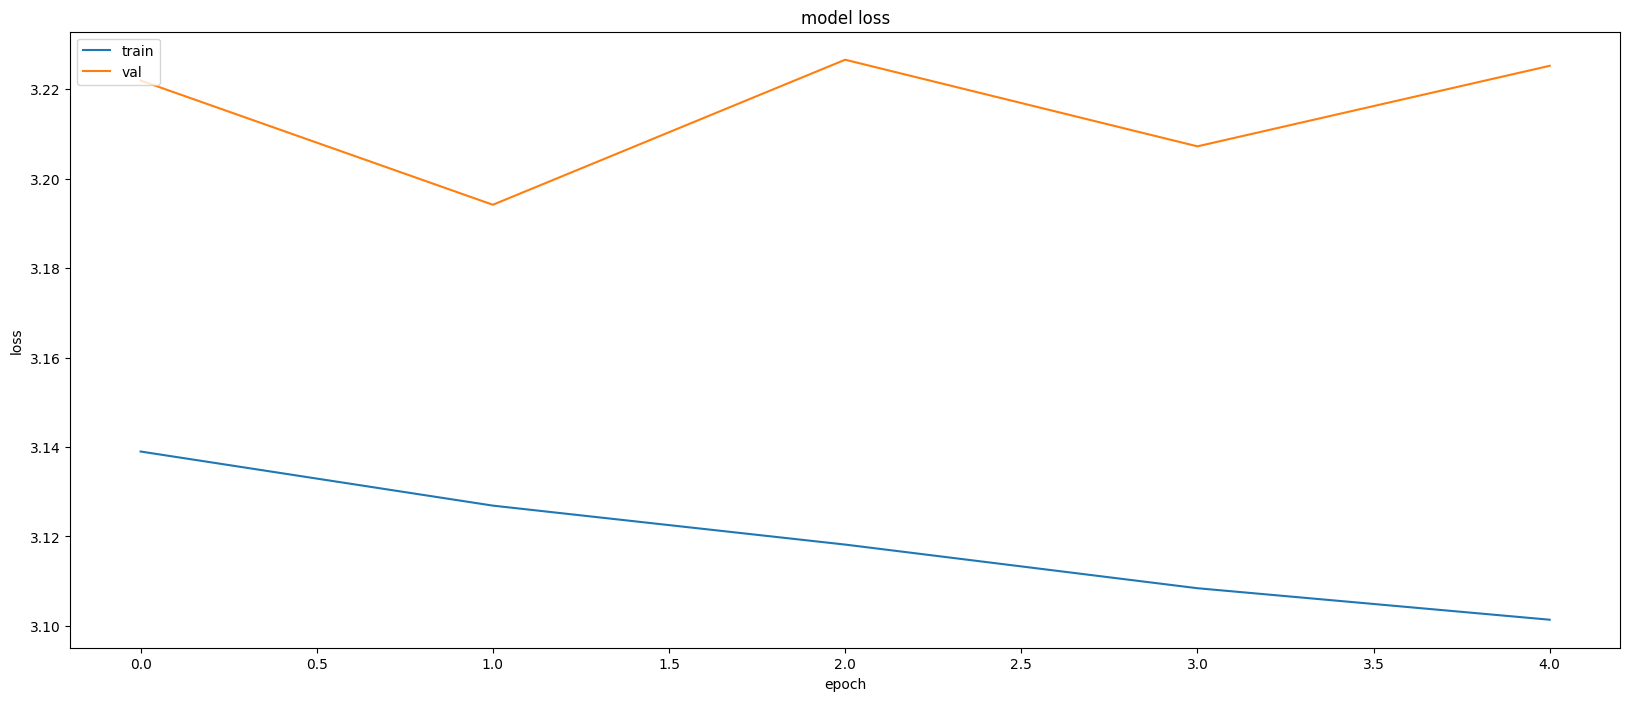

In [466]:
plt.figure(figsize=(20,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

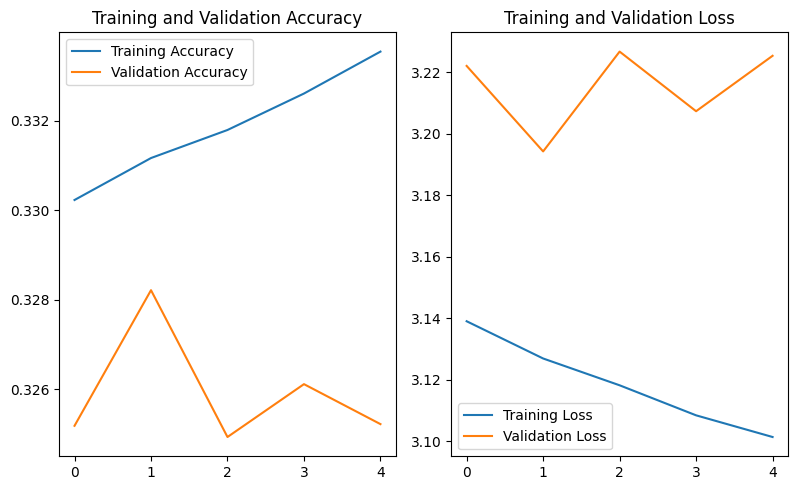

In [467]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [461]:
def generate_caption(model, image_feature, tokenizer, max_length):
    # Start the sequence with the start token
    in_text = 'sseq'
    for i in range(max_length):
        # Convert the text input to integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict the next word
        yhat = model.predict([image_feature, sequence], verbose=0)
        # Convert the probability to integer
        yhat = np.argmax(yhat)
        # Map integer to word
        word = word_for_id(yhat, tokenizer)
        # Break if we reach the end of the sequence
        if word == 'eseq':
            break
        # Append the word to the sequence
        in_text += ' ' + word
    # Remove the start token before returning the caption
    final_caption = in_text.split(' ', 1)[1]
    return final_caption

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def get_feature(filename):
    for image_name, feature in selected_features.items():
        if filename == image_name:
            feature = np.array(feature).reshape((1, 4096))
    return feature

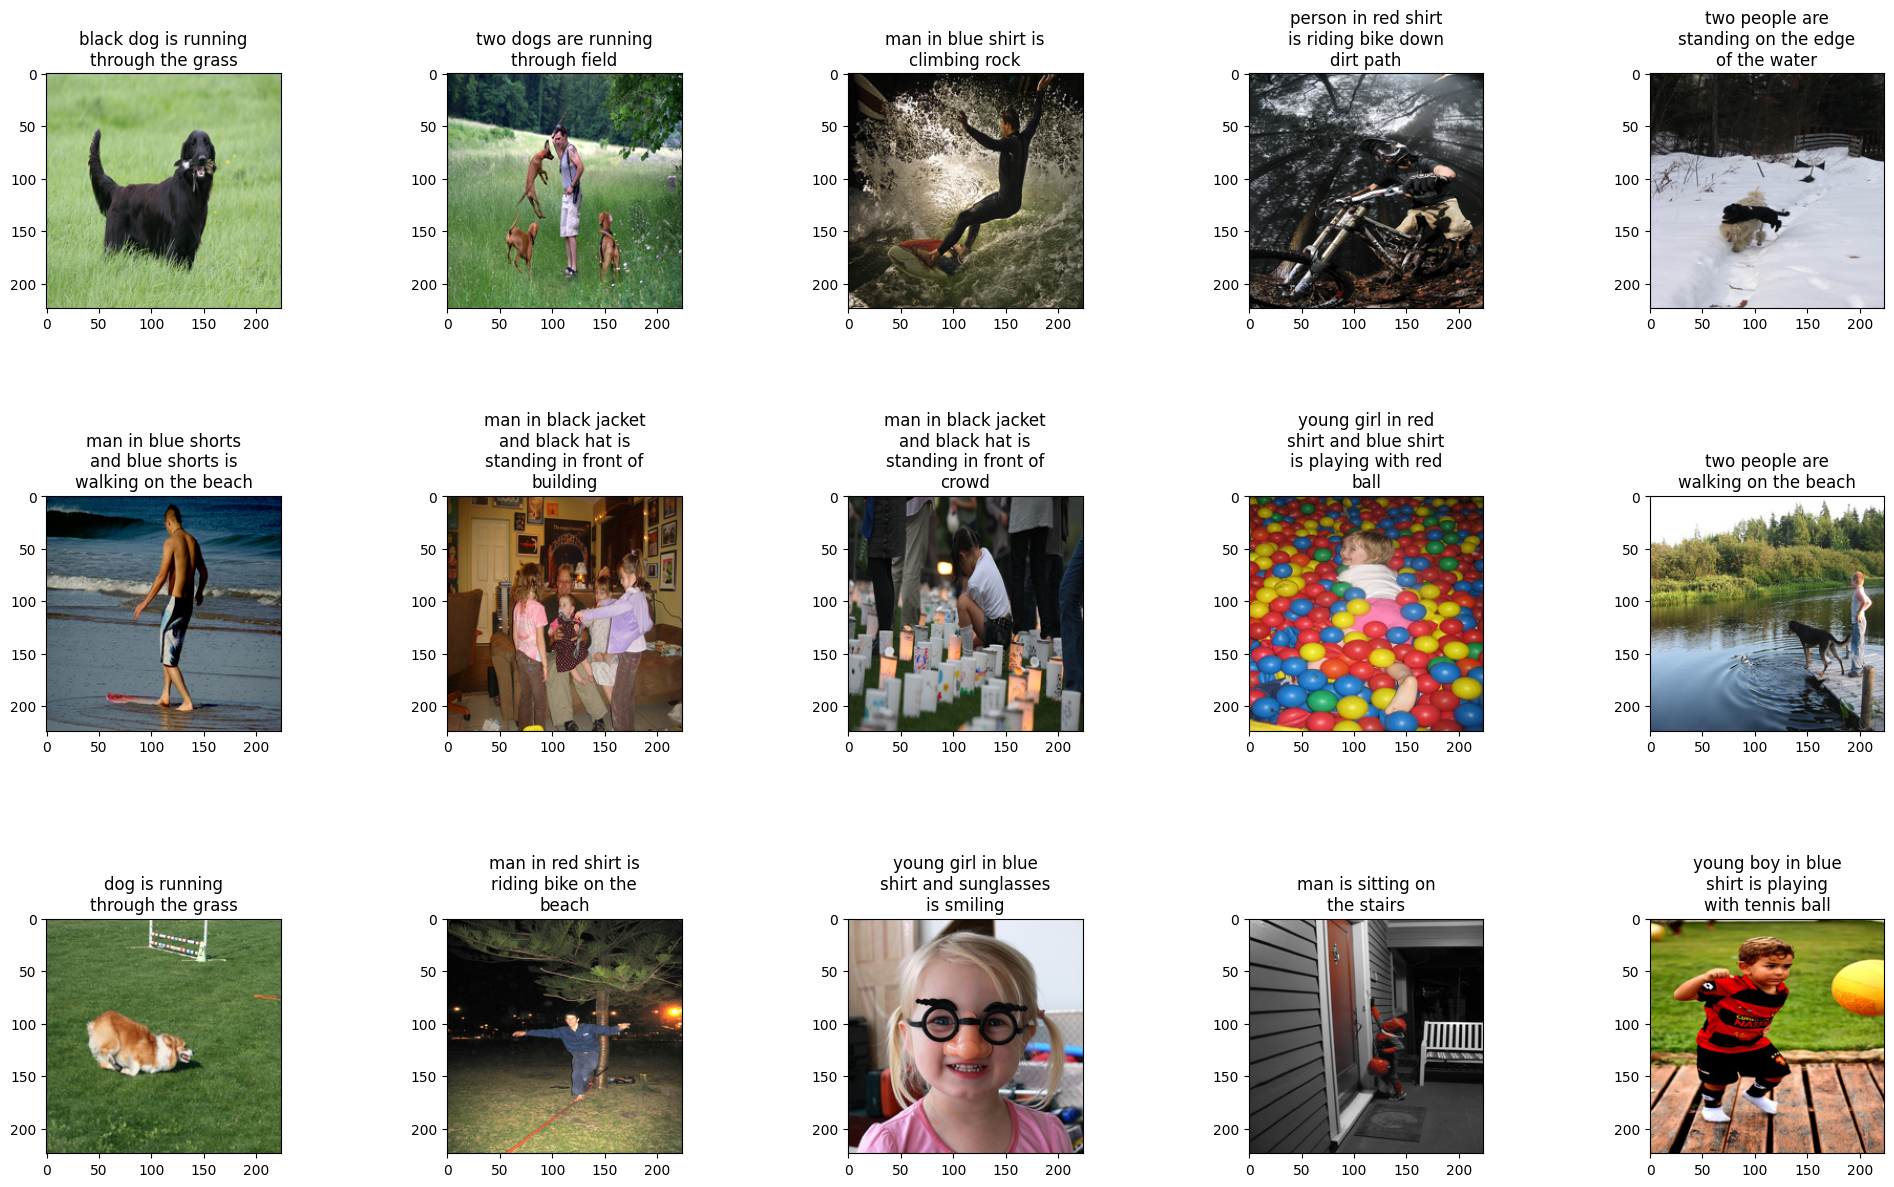

In [468]:
# Select 15 random images
random_images = random.sample(images, 15)
# Retrieve corresponding features for the selected 15 images
selected_features = {image_name: features1[image_name] for image_name in random_images if image_name in features1}

for image_name, _ in selected_features.items():
    selected_features[image_name] = generate_caption(model, selected_features[image_name], tokenizer, max_length)

plt.figure(figsize=(25, 25))

for i,(image_name, new_caption) in enumerate(selected_features.items()):
    if os.path.splitext(image_name)[1].lower() not in valid_imgExt:
        continue
    with open(os.path.join(image_path, image_name), 'rb') as img:
        img = Image.open(img).resize(image_size[2])
        plt.subplot(5, 5, i+1)
        plt.imshow(img)
        plt.title("\n".join(wrap(new_caption, 20)))
        plt.subplots_adjust(hspace=0.8)
        img.close()
plt.show()

In [323]:
print('''We observe that a simple network yields poor results.
There is evidence of significant overfitting: repeated 'eseq' words.

Now we attempt to use a more complex model by:
(1) adding more Bidirectional LSTM layers
(2) increasing the neuron dropout rate
(3) using L2 regulariser''')

We observe that a simple network yields poor results.
There is evidence of significant overfitting: repeated 'eseq' words.

Now we attempt to use a more complex model by:
(1) adding more Bidirectional LSTM layers
(2) increasing the neuron dropout rate
(3) using L2 regulariser


In [ ]:
from keras_tuner import HyperModel
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from keras_tuner import RandomSearch

class ImageCaptioningHyperModel(HyperModel):
    def __init__(self, vocab_size, max_length, input_shape):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.input_shape = input_shape

    def build(self, hp):
        input1 = Input(shape=(self.input_shape,))
        input2 = Input(shape=(self.max_length,))
        
        hp_dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
        hp_lstm_units_1 = hp.Int('lstm_units_1', min_value=64, max_value=256, step=32)
        hp_lstm_units_2 = hp.Int('lstm_units_2', min_value=64, max_value=256, step=32)
        
        img_features = Dropout(hp_dropout_rate)(input1)
        img_features = Dense(256, activation='relu')(img_features)

        sentence_features = Embedding(self.vocab_size, 256, mask_zero=False)(input2)
        sentence_features = Dropout(hp_dropout_rate)(sentence_features)
        sentence_features = Bidirectional(LSTM(hp_lstm_units_1, return_sequences=True, kernel_regularizer=l2(1e-4)))(sentence_features)
        sentence_features = Bidirectional(LSTM(hp_lstm_units_2, return_sequences=False, kernel_regularizer=l2(1e-4)))(sentence_features)

        merged = concatenate([img_features, sentence_features], axis=1)
        decoder = Dense(256, activation='relu')(merged)
        outputs = Dense(self.vocab_size, activation='softmax')(decoder)

        model_tuning = Model(inputs=[input1, input2], outputs=outputs)
        model_tuning.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        return model

hypermodel = ImageCaptioningHyperModel(vocab_size=vocab_size, max_length=max_length, input_shape=4096)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir',
    project_name='image_captioning'
)

tuner.search(
    train_generator1, 
    validation_data=val_generator1, 
    epochs=num_epochs,
    callbacks=[early_stop, lr_scheduler]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first LSTM layer is {best_hps.get('lstm_units_1')} and in the second LSTM layer is {best_hps.get('lstm_units_2')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
""")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 35, 256)              2157312   ['input_4[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 dropout_3 (Dropout)         (None, 35, 256)              0         ['embedding_1[0][0]']         
                                                                                            

Python(20775) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(20777) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


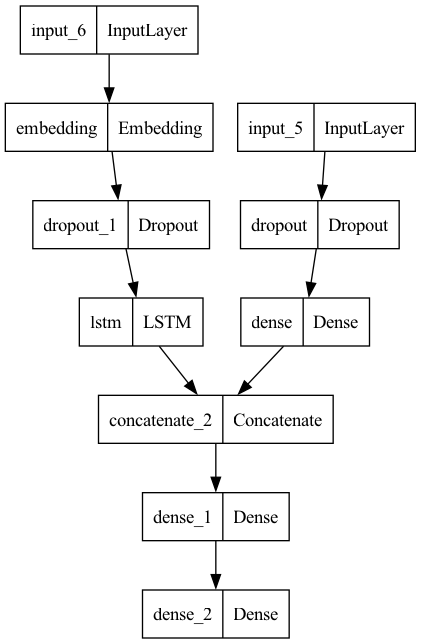

In [407]:
input1 = Input(shape=(4096,))
input2 = Input(shape=(max_length,))
l2_reg = l2(1e-4)

img_features_1 = Dropout(0.5)(input1)
img_features_2 = Dense(256, activation='relu')(img_features_1)

sentence_features_1 = Embedding(vocab_size, 256, mask_zero=False)(input2)
sentence_features_2 = Dropout(0.5)(sentence_features_1)
sentence_features_3 = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2_reg))(sentence_features_2)
sentence_features_4 = Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2_reg))(sentence_features_3)

merged = concatenate([img_features_2, sentence_features_4], axis=1)
decoder = Dense(256, activation='relu')(merged)
output = Dense(vocab_size, activation='softmax')(decoder)

model_improved = Model(inputs=[input1, input2], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_improved.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_improved.summary()
plot_model(model)

In [408]:
hist_improved = model_improved.fit(
    train_generator1,
    steps_per_epoch=len(train_descriptions)//batch_size,
    epochs=num_epochs,
    validation_data=val_generator1,
    validation_steps=len(val_descriptions)//batch_size,
    verbose=1,
    callbacks=[early_stop, reduce_lr],
    batch_size=batch_size
)
model_improved.save('modelImproved_vgg16_8k.h5')

# NOTE: Uncomment this code to import saved model
# model_improved = load_model('modelImproved_vgg16_8k.h5')

Epoch 1/50
107/107 [==============================] - 1072s 10s/step - loss: 5.8318 - accuracy: 0.1085 - val_loss: 5.3140 - val_accuracy: 0.1395 - lr: 0.0010
Epoch 2/50
107/107 [==============================] - 1308s 12s/step - loss: 5.2210 - accuracy: 0.1416 - val_loss: 5.0784 - val_accuracy: 0.1527 - lr: 0.0010
Epoch 3/50
107/107 [==============================] - 1200s 11s/step - loss: 5.0167 - accuracy: 0.1544 - val_loss: 4.9620 - val_accuracy: 0.1727 - lr: 0.0010
Epoch 4/50
107/107 [==============================] - 977s 9s/step - loss: 4.8504 - accuracy: 0.1714 - val_loss: 4.8324 - val_accuracy: 0.1824 - lr: 0.0010
Epoch 5/50
107/107 [==============================] - 947s 9s/step - loss: 4.7366 - accuracy: 0.1772 - val_loss: 4.7564 - val_accuracy: 0.1887 - lr: 0.0010
Epoch 6/50
107/107 [==============================] - 945s 9s/step - loss: 4.6001 - accuracy: 0.1865 - val_loss: 4.6632 - val_accuracy: 0.1974 - lr: 9.0484e-04
Epoch 7/50
107/107 [==============================] - 

/Users/chufeng/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


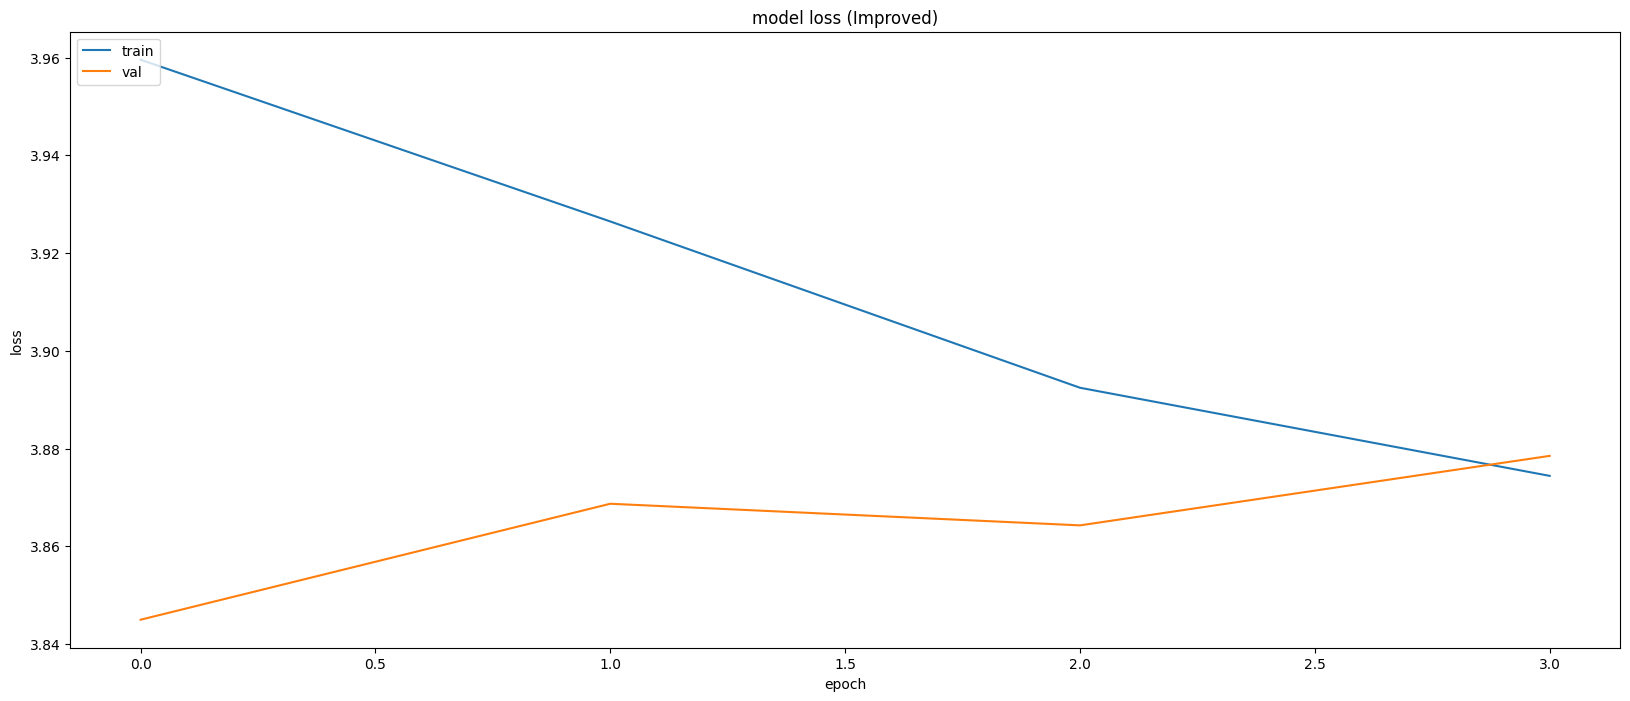

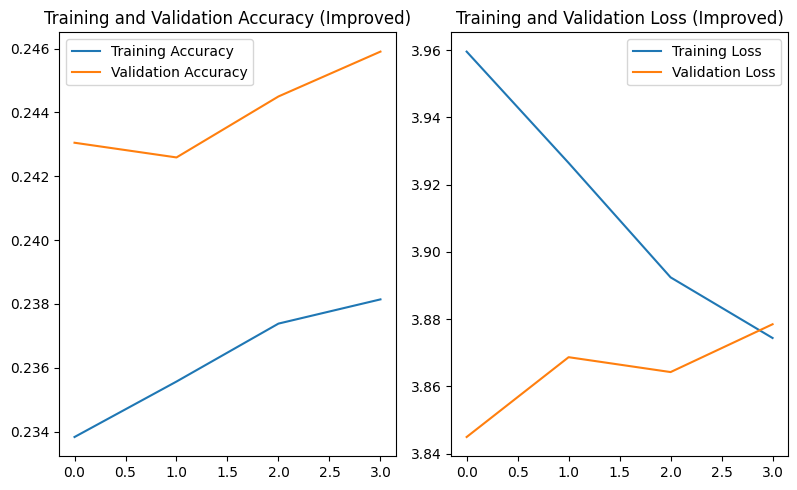

In [451]:
plt.figure(figsize=(20,8))
plt.plot(hist_improved.history['loss'])
plt.plot(hist_improved.history['val_loss'])
plt.title('model loss (Improved)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

acc = hist_improved.history['accuracy']
val_acc = hist_improved.history['val_accuracy']
loss = hist_improved.history['loss']
val_loss = hist_improved.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Improved)')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (Improved)')

plt.tight_layout()
plt.show()

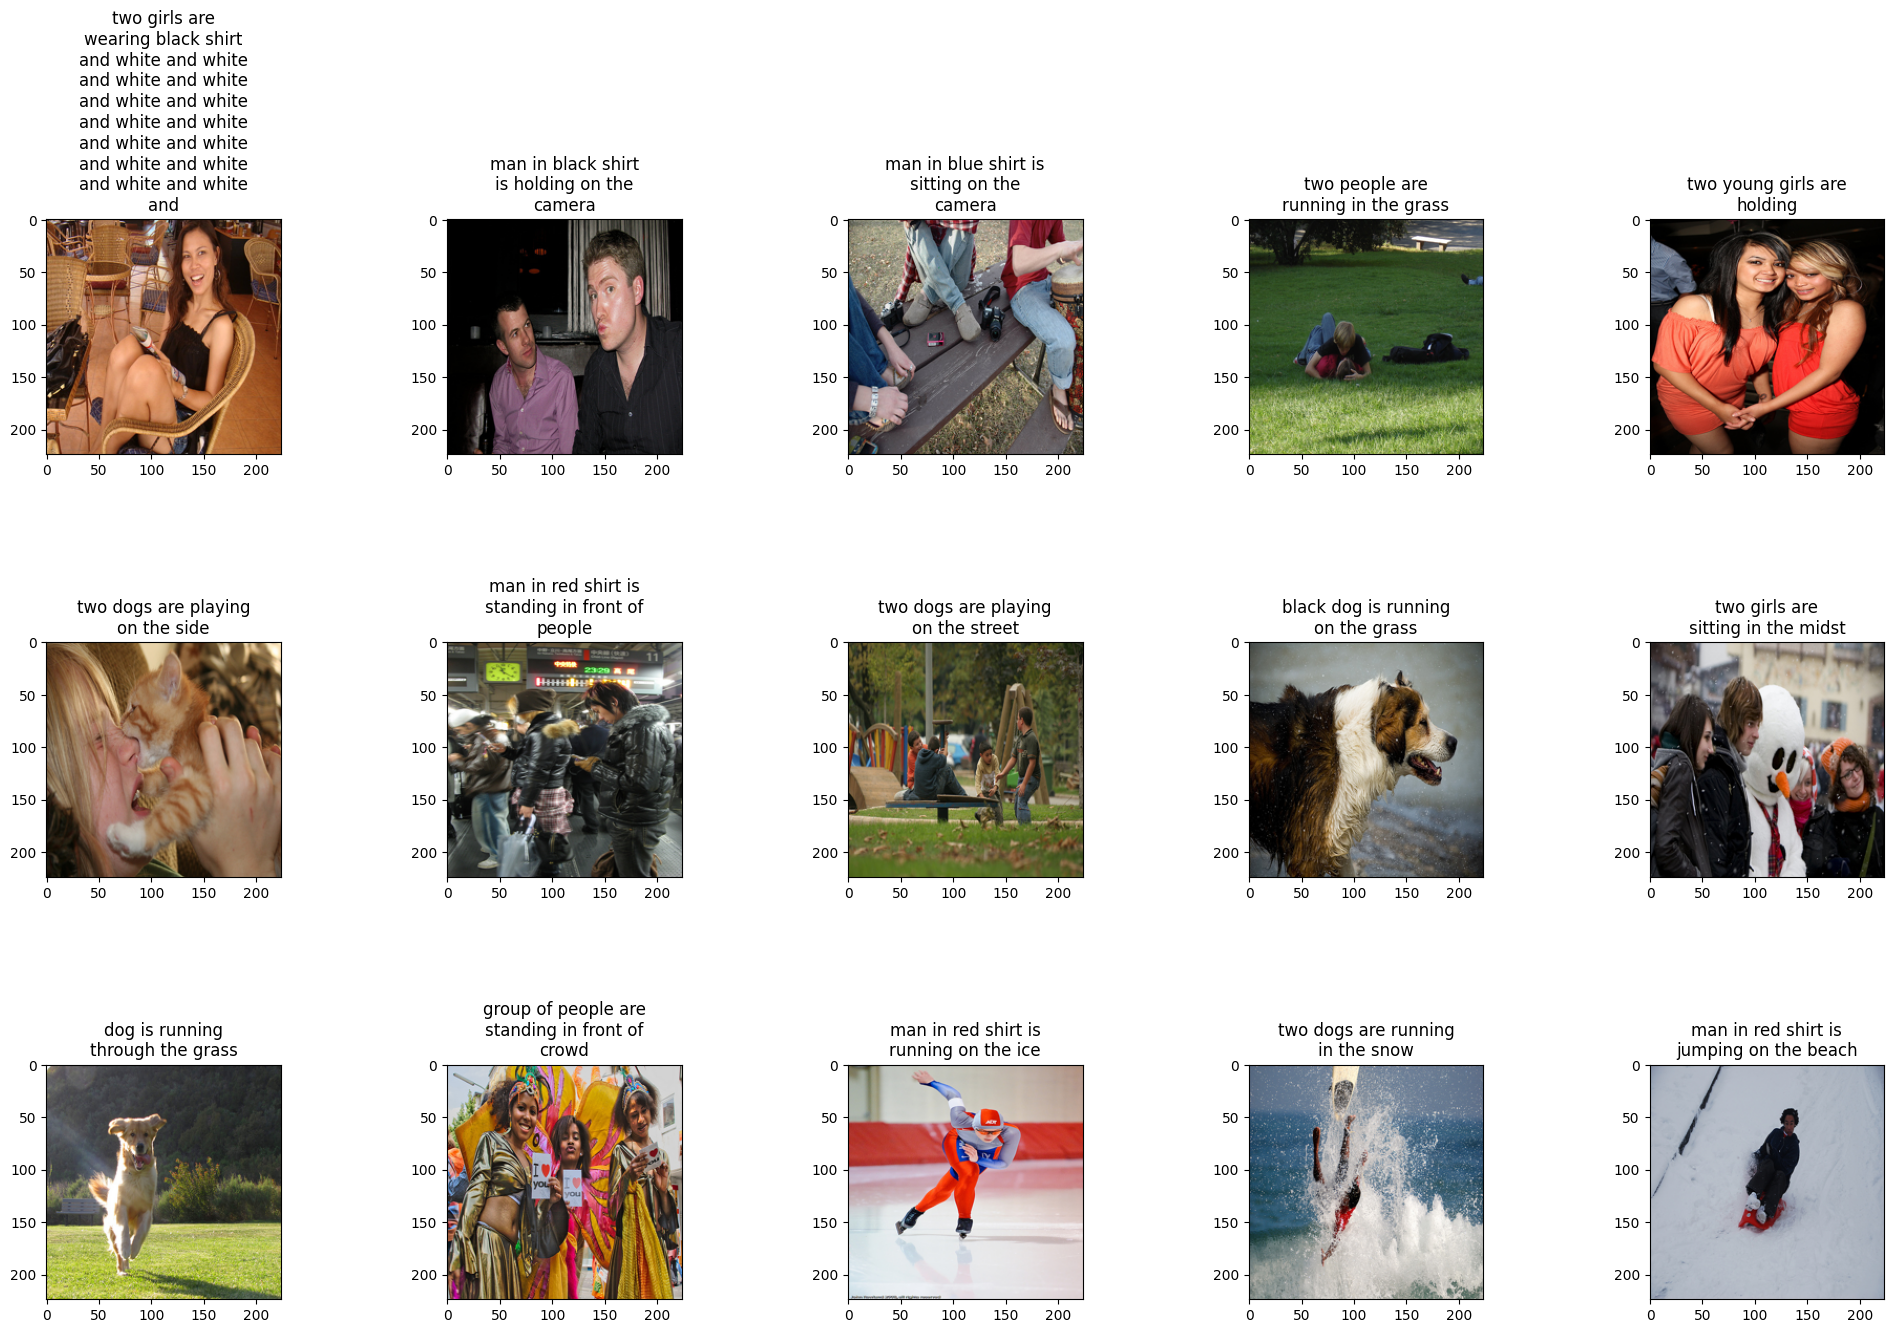

In [453]:
# Select 15 random images
random_images = random.sample(images, 15)
# Retrieve corresponding features for the selected 15 images
selected_features = {image_name: features1[image_name] for image_name in random_images if image_name in features1}

for image_name, _ in selected_features.items():
    selected_features[image_name] = generate_caption(model_improved, selected_features[image_name], tokenizer, max_length)

plt.figure(figsize=(25, 25))

for i,(image_name, new_caption) in enumerate(selected_features.items()):
    if os.path.splitext(image_name)[1].lower() not in valid_imgExt:
        continue
    with open(os.path.join(image_path, image_name), 'rb') as img:
        img = Image.open(img).resize(image_size[2])
        plt.subplot(5, 5, i+1)
        plt.imshow(img)
        plt.title("\n".join(wrap(new_caption, 20)))
        plt.subplots_adjust(hspace=0.8)
        img.close()
plt.show()

In [ ]:
input1 = Input(shape=(4096,))
input2 = Input(shape=(max_length,))
l2_reg = l2(1e-4)

img_features_1 = Dropout(0.5)(input1)
img_features_2 = Dense(256, activation='relu')(img_features_1)

sentence_features_1 = Embedding(vocab_size, 256, mask_zero=False, trainable=True)(input2)
sentence_features_2 = Dropout(0.5)(sentence_features_1)
sentence_features_3 = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2_reg))(sentence_features_2)
sentence_features_4 = Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2_reg))(sentence_features_3)

merged = concatenate([img_features_2, sentence_features_4], axis=1)
decoder = Dense(256, activation='relu')(merged)
output = Dense(vocab_size, activation='softmax')(decoder)

model_improved = Model(inputs=[input1, input2], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_improved.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_improved.summary()
plot_model(model)

In [ ]:
hist_improved = model_improved.fit(
    train_generator1,
    steps_per_epoch=len(train_descriptions)//batch_size,
    epochs=num_epochs,
    validation_data=val_generator1,
    validation_steps=len(val_descriptions)//batch_size,
    verbose=1,
    callbacks=[early_stop, lr_scheduler],
    batch_size=batch_size
)
model_improved.save('modelImprovedT_vgg16_8k.h5')

# NOTE: Uncomment this code to import saved model
# model_improved = load_model('modelImproved_vgg16_8k.h5')

### 3.3 Train the model using different CNN models

### 3.3.1 DenseNet201

### 3.3.2 ResNet50

### 3.3.3 InceptionV3

### 3.4 Evaluate CNN models

### 4.1